## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-05-18 06:57:46.073205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 06:57:47.085918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.networks.nets import ResNet
from monai.networks.nets import EfficientNetBN
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.dev2320
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 05e84bf40ed7b2a6bebf4d1c6d4f97f829231cc0
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/install

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpqclo_nrg


In [ ]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:00, 84.3MB/s]                            

2023-05-18 06:58:31,077 - INFO - Downloaded: /tmp/tmpqclo_nrg/MedNIST.tar.gz


2023-05-18 06:58:31,190 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-05-18 06:58:31,192 - INFO - Writing into directory: /tmp/tmpqclo_nrg.


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size
print(PIL.Image.open(image_files_list[0]))
print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=64x64 at 0x7F6CE96824A0>
Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

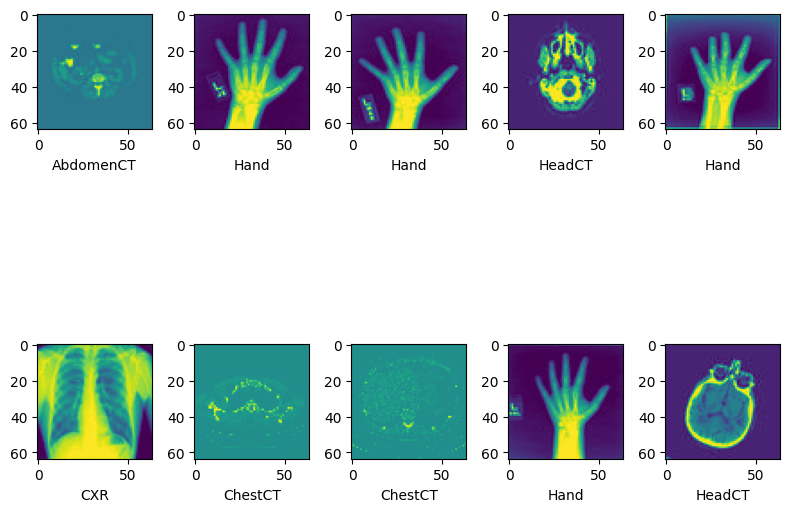

In [ ]:
plt.subplots(2, 5, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=10)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(2, 5, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

workers = 2
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
class GCNN_ECNN(nn.Module):
    def __init__(self, img_size=64, pred_edge=False):
        super(GCNN_ECNN, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 6, bias=True)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]]) # this should have worked
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64), # this can be a hyperparameter 
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)  
        sigma = 0.05 * np.pi

        
        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')
            
        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        # print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)



In [ ]:
model = GCNN_ECNN(pred_edge=True)

In [ ]:
print(sum(p.numel() for p in model.parameters()))

24582


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric() 
model.to(device)

In [ ]:
import time

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for_time = []
    back_time = []
    for batch_data in train_loader:
        # print(batch_data[0].shape)
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        a = time.time()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        b = time.time()
        loss.backward()
        c = time.time()
        optimizer.step()
        d = time.time()
        for_time.append(b-a)
        #print("forward",sum(for_time)/len(for_time))
        epoch_loss += loss.item()
        back_time.append(c-b)
        # print("backward",sum(back_time)/len(back_time))

        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.4208
2/157, train_loss: 1.4451
3/157, train_loss: 1.3781
4/157, train_loss: 1.3909
5/157, train_loss: 1.4570
6/157, train_loss: 1.4117
7/157, train_loss: 1.3825
8/157, train_loss: 1.2532
9/157, train_loss: 1.2059
10/157, train_loss: 1.2828
11/157, train_loss: 1.3108
12/157, train_loss: 1.2679
13/157, train_loss: 1.2503
14/157, train_loss: 1.3369
15/157, train_loss: 1.1147
16/157, train_loss: 1.2088
17/157, train_loss: 1.1681
18/157, train_loss: 1.1820
19/157, train_loss: 1.2069
20/157, train_loss: 1.1265
21/157, train_loss: 1.2104
22/157, train_loss: 1.0668
23/157, train_loss: 1.1840
24/157, train_loss: 1.2234
25/157, train_loss: 1.1189
26/157, train_loss: 1.1484
27/157, train_loss: 1.2335
28/157, train_loss: 1.0980
29/157, train_loss: 1.0621
30/157, train_loss: 1.2754
31/157, train_loss: 1.0262
32/157, train_loss: 1.1230
33/157, train_loss: 1.2053
34/157, train_loss: 1.0893
35/157, train_loss: 1.1270
36/157, train_loss: 1.1020
37/157, train_lo

## Plot the loss and metric

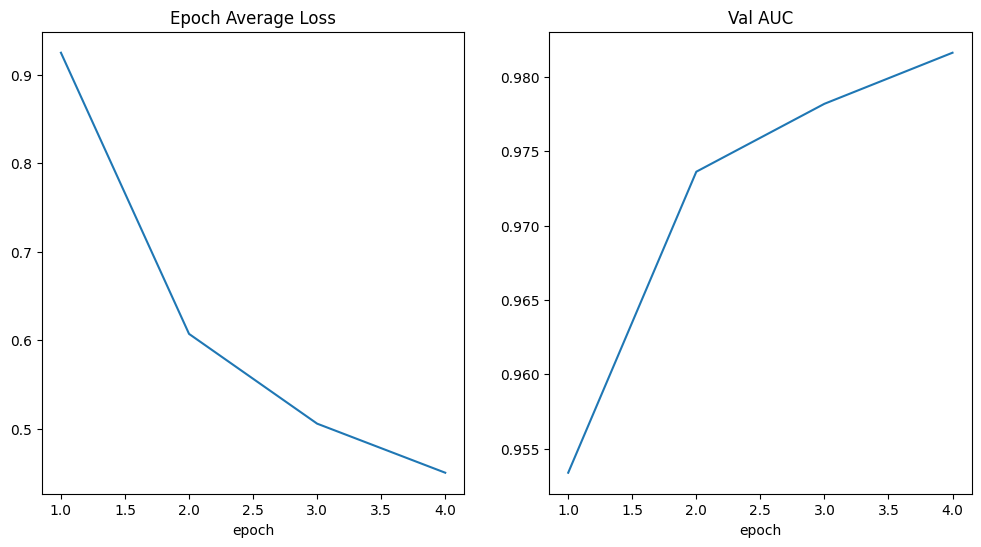

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.6779    0.8860    0.7681       974
   BreastMRI     0.9921    0.9932    0.9927       884
         CXR     0.9637    0.9627    0.9632       992
     ChestCT     0.8512    0.6547    0.7401      1031
        Hand     0.9102    0.9147    0.9124      1008
      HeadCT     0.9255    0.8648    0.8941      1006

    accuracy                         0.8758      5895
   macro avg     0.8868    0.8794    0.8784      5895
weighted avg     0.8854    0.8758    0.8759      5895



## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)